# tsam - Duration representation
Example usage of the time series aggregation module (tsam)
Date: 27.06.2019

Author: Leander Kotzur

Import pandas and the relevant time series aggregation class

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
import tsam.timeseriesaggregation as tsam
%matplotlib inline

### Input data 

Read in time series from testdata.csv with pandas

In [2]:
raw = pd.read_csv('testdata.csv', index_col = 0)

Create a plot function for the temperature for a visual comparison of the time series

In [3]:
def plotTS(data, periodlength, vmin, vmax, label = 'T [°C]'):
    fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('Hour')
    plt.xlabel('Day')

    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label(label)

### Hierarchical aggregation with medoid representation

Initialize an aggregation class object with hierarchical as method for eight typical days

In [4]:
aggregation = tsam.TimeSeriesAggregation(raw, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                        clusterMethod = 'hierarchical')

Create the typical periods

In [5]:
typPeriods = aggregation.createTypicalPeriods()

Get accuracy indicators

In [6]:
aggregation.accuracyIndicators()

,RMSE,RMSE_duration,MAE
GHI,0.094709,0.030927,0.050724
Load,0.101172,0.031669,0.071986
T,0.089186,0.034249,0.069773
Wind,0.144894,0.049622,0.113727


Get intraday variance in normalized space of clustered time series

In [7]:
aggregation.normalizedTypicalPeriods.unstack(level=0).var().unstack().mul(aggregation._clusterPeriodNoOccur).sum(axis=1)

GHI     12.122745
Load     7.751479
T        0.694683
Wind     2.279039
dtype: float64

Get intraday variance in normalized space of original time series

In [8]:
aggregation.normalizedPeriodlyProfiles.stack(level=0).var(axis=1).unstack().sum()

GHI     13.926991
Load     7.651419
T        1.080296
Wind     3.536932
dtype: float64

In [9]:
predictedPeriods = aggregation.predictOriginalData()

### Hierarchical aggregation with duration representation

In [10]:
aggregation = tsam.TimeSeriesAggregation(raw, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                        clusterMethod = 'hierarchical', durationRepresentation = True,
                                        solver = 'gurobi', rescaleClusterPeriods = False)

/home/leander/workspace/tsam/tsam/timeseriesaggregation.py:452: UserWarning: durationRepresentation" is in development phase and can significantly slow down the aggregation for large scale time series
  'and can significantly slow down the aggregation for large scale time series')


In [11]:
typPeriods = aggregation.createTypicalPeriods()

Get accuracy indicators

In [12]:
aggregation.accuracyIndicators()

,RMSE,RMSE_duration,MAE
GHI,0.100473,0.006692,0.050418
Load,0.104449,0.004966,0.074557
T,0.099402,0.003760,0.077662
Wind,0.156443,0.010086,0.118151


Get intraday variance in normalized space of clustered time series

In [13]:
aggregation.normalizedTypicalPeriods.unstack(level=0).var().unstack().mul(aggregation._clusterPeriodNoOccur).sum(axis=1)

GHI     14.651817
Load     9.841858
T        3.099746
Wind     5.916289
dtype: float64

In [14]:
predictedPeriodsDur = aggregation.predictOriginalData()

### Comparison of the aggregations 
It was shown for the temperature, but both times all four time series have been aggregated. Therefore, we compare here also the duration curves  of the electrical load for the original time series, the aggregation with k-mean, and the hierarchical aggregation including peak periods.

Text(0,0.5,'Duration Load [MW]')

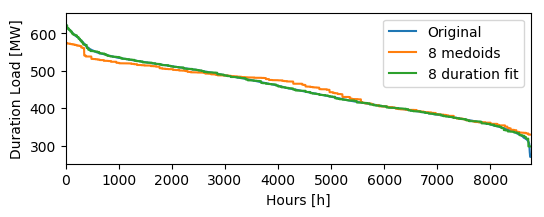

In [15]:
fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
raw['Load'].sort_values(ascending=False).reset_index(drop=True).plot(label = 'Original')
predictedPeriods['Load'].sort_values(ascending=False).reset_index(drop=True).plot(label = '8 medoids')
predictedPeriodsDur['Load'].sort_values(
    ascending=False).reset_index(drop=True).plot(label = '8 duration fit')
plt.legend()
plt.xlabel('Hours [h]')
plt.ylabel('Duration Load [MW]')

Show temperature **raw**

In [16]:
param = 'T'

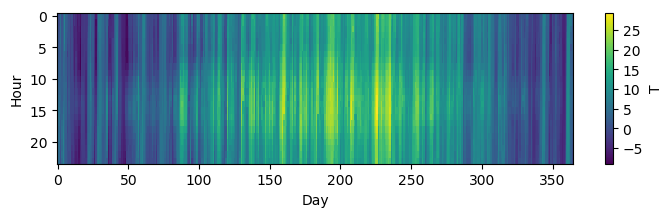

In [17]:
plotTS(raw[param], 24, vmin = raw[param].min(), vmax = raw[param].max(), label = param)

Show temperature **medoids**

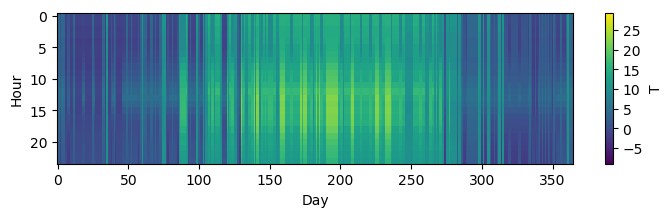

In [18]:
plotTS(predictedPeriods[param], 24, vmin = raw[param].min(), vmax = raw[param].max(), label = param)

Show temperature **duration fit**

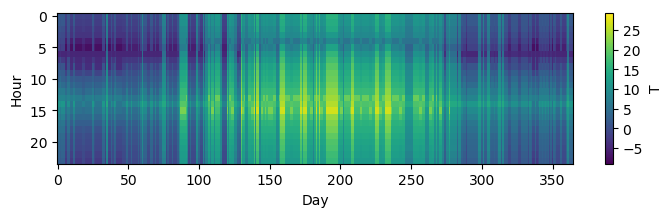

In [19]:
plotTS(predictedPeriodsDur[param], 24, vmin = raw[param].min(), vmax = raw[param].max(), label = param)

Or as unsorted time series for an example week

Text(0,0.5,'Load [MW]')

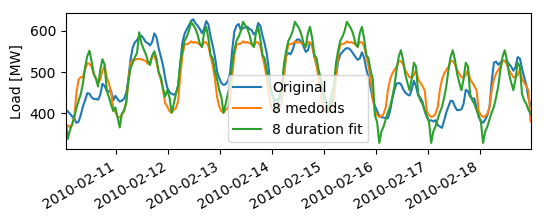

In [20]:
fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
raw['Load']['20100210':'20100218'].plot(label = 'Original')
predictedPeriods['Load']['20100210':'20100218'].plot(label = '8 medoids')
predictedPeriodsDur['Load']['20100210':'20100218'].plot(label = '8 duration fit')
plt.legend()
plt.ylabel('Load [MW]')